# Fine Tuning Phi 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1: Import required libraries and set up environment
!pip install -U torch transformers datasets peft sentence-transformers bitsandbytes
!pip install python-docx
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.w

In [3]:
import os
import torch
import random
import re
import json
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login

In [4]:
# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

In [5]:
# Cell 2: Set up model and tokenizer
model_name = "tiiuae/falcon-7b"
output_dir = "/content/drive/MyDrive/results_falcon7b_qlora"

# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


In [6]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [7]:
# Cell 3: Prepare the model for training
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h"
    ],
    lora_dropout=0.2,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [8]:
# Cell 4: Load and preprocess a single training example
with open("TeleQnA_training.txt", "r") as f:
    train_data = json.load(f)

# Process a single example
example_key = list(train_data.keys())[0]
example_data = train_data[example_key]

In [9]:
# Process a single example
example_key

'question 0'

In [10]:
example_data

{'question': 'What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation? [3GPP Release 18]',
 'option 1': 'To configure the MFAF to map data or analytics received by the MFAF to out-bound notification endpoints',
 'option 2': 'To configure the MFAF to stop mapping data or analytics received by the MFAF to out-bound notification endpoints',
 'option 3': 'To supply data or analytics from the MFAF to notification endpoints',
 'option 4': 'To fetch data or analytics from the MFAF based on fetch instructions',
 'answer': 'option 2: To configure the MFAF to stop mapping data or analytics received by the MFAF to out-bound notification endpoints',
 'explanation': 'The Nmfaf_3daDataManagement_Deconfigure service operation is used to stop mapping data or analytics received by the MFAF to one or more out-bound notification endpoints.',
 'category': 'Standards specifications'}

In [11]:
def format_single_example(question_data):
    prompt = f"Question: {question_data['question']}\n"
    prompt += "Options:\n"
    for i in range(1, 5):
        option_key = f"option {i}"
        if option_key in question_data:
            prompt += f"{i}. {question_data[option_key]}\n"
    prompt += f"Answer: {question_data['answer']}\n"
    prompt += f"Explanation: {question_data['explanation']}"
    return prompt

single_example = format_single_example(example_data)
print("Single example:")
print(single_example)


Single example:
Question: What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation? [3GPP Release 18]
Options:
1. To configure the MFAF to map data or analytics received by the MFAF to out-bound notification endpoints
2. To configure the MFAF to stop mapping data or analytics received by the MFAF to out-bound notification endpoints
3. To supply data or analytics from the MFAF to notification endpoints
4. To fetch data or analytics from the MFAF based on fetch instructions
Answer: option 2: To configure the MFAF to stop mapping data or analytics received by the MFAF to out-bound notification endpoints
Explanation: The Nmfaf_3daDataManagement_Deconfigure service operation is used to stop mapping data or analytics received by the MFAF to one or more out-bound notification endpoints.


In [12]:
# Cell 5: Update tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Test the tokenize function on a single example
single_example_dataset = Dataset.from_dict({"text": [single_example]})
tokenized_single_example = single_example_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
print("Tokenized single example:")
print(tokenized_single_example[0])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Tokenized single example:
{'input_ids': [19700, 37, 1634, 304, 248, 4099, 275, 248, 409, 63437, 1622, 74, 30, 4239, 3911, 30459, 74, 9764, 245, 27372, 1506, 5814, 42, 204, 70, 30, 50, 13731, 13528, 204, 1121, 72, 193, 12340, 37, 193, 28, 25, 1472, 18606, 248, 53549, 49, 271, 4769, 1211, 379, 12810, 3245, 431, 248, 53549, 49, 271, 495, 24, 11081, 15011, 48315, 193, 29, 25, 1472, 18606, 248, 53549, 49, 271, 2663, 17179, 1211, 379, 12810, 3245, 431, 248, 53549, 49, 271, 495, 24, 11081, 15011, 48315, 193, 30, 25, 1472, 4322, 1211, 379, 12810, 427, 248, 53549, 49, 271, 15011, 48315, 193, 31, 25, 1472, 23894, 1211, 379, 12810, 427, 248, 53549, 49, 1934, 313, 23894, 7104, 193, 20309, 37, 2773, 204, 29, 37, 1472, 18606, 248, 53549, 49, 271, 2663, 17179, 1211, 379, 12810, 3245, 431, 248, 53549, 49, 271, 495, 24, 11081, 15011, 48315, 193, 1939, 64678, 37, 390, 409, 63437, 1622, 74, 30, 4239, 3911, 30459, 74, 9764, 245, 27372, 1506, 5814, 304, 1042, 271, 2663, 17179, 1211, 379, 12810, 3245, 431, 

In [13]:
len(tokenized_single_example[0]["input_ids"])

512

In [14]:
# Cell 6: Process all training data
train_texts = [format_single_example(question_data) for question_data in train_data.values()]

# Create a dataset
dataset = Dataset.from_dict({"text": train_texts})

# Split the dataset into train and validation
train_val_dataset = dataset.train_test_split(test_size=0.1, seed=42)

# Tokenize the datasets
tokenized_train_dataset = train_val_dataset["train"].map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val_dataset = train_val_dataset["test"].map(tokenize_function, batched=True, remove_columns=["text"])

print(f"Training dataset size: {len(tokenized_train_dataset)}")
print(f"Validation dataset size: {len(tokenized_val_dataset)}")

# Optionally, print a sample from the tokenized dataset to verify
print("\nSample from tokenized training dataset:")
print(tokenized_train_dataset[0])

Map:   0%|          | 0/1314 [00:00<?, ? examples/s]

Map:   0%|          | 0/147 [00:00<?, ? examples/s]

Training dataset size: 1314
Validation dataset size: 147

Sample from tokenized training dataset:
{'input_ids': [19700, 37, 1634, 4847, 1365, 5171, 24455, 272, 1307, 11936, 42, 204, 70, 30, 50, 13731, 13528, 204, 1121, 72, 193, 12340, 37, 193, 28, 25, 390, 6406, 8768, 304, 2426, 1029, 427, 248, 30715, 1709, 4193, 193, 29, 25, 390, 3041, 5029, 17129, 267, 26372, 11936, 1769, 193, 30, 25, 317, 1714, 2218, 275, 6398, 304, 15018, 313, 248, 30715, 18, 94, 1709, 193, 31, 25, 390, 319, 5371, 12145, 241, 11575, 5930, 61, 193, 20309, 37, 2773, 204, 32, 37, 390, 1881, 275, 27837, 38162, 304, 5887, 271, 248, 30715, 18, 94, 1709, 193, 1939, 64678, 37, 6599, 5171, 24455, 272, 1307, 11936, 23, 248, 1881, 275, 607, 27837, 38162, 304, 5887, 431, 248, 3041, 5029, 271, 248, 432, 7563, 26, 4724, 62, 23, 585, 832, 6930, 334, 271, 248, 30715, 18, 94, 1709, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 

In [ ]:

# Cell 7: Set up training arguments
from transformers import EarlyStoppingCallback



from transformers import TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,  # Increase epochs, will be overridden by max_steps
    per_device_train_batch_size=2,  # Increase if memory allows
    gradient_accumulation_steps=4,
    learning_rate=5e-5,  # Reduced learning rate
    max_steps=200,  # Increased steps
    fp16=True,
    save_steps=20,
    logging_steps=20,
    evaluation_strategy="steps",
    eval_steps=20,
    save_total_limit=3,
    load_best_model_at_end=True,
    optim="adamw_torch",
    max_grad_norm=1.0,
    warmup_ratio=0.1,  # 10% of steps for warmup
    lr_scheduler_type="cosine",  # Cosine decay after warmup
    report_to="none",
    gradient_checkpointing=False,
)

# Add early stopping
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Set up Trainer
model.config.use_cache = False

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    callbacks=[early_stopping_callback]
)

# # Start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  retu

Step,Training Loss,Validation Loss
20,1.889700,1.486755


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


In [19]:
# Extract training and validation loss
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

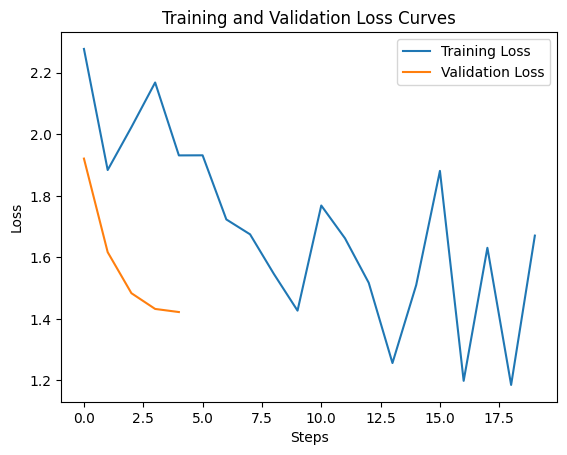

In [20]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

In [ ]:

# Cell 9: Save the fine-tuned model
model.save_pretrained(os.path.join(output_dir, "final_model"))
tokenizer.save_pretrained(os.path.join(output_dir, "final_model"))

print("Training completed and model saved!")


Training completed and model saved!


In [ ]:

# Cell 10: Load test data and process a single example
with open("TeleQnA_testing1.txt", "r") as f1:
    test_data1 = json.load(f1)

with open("questions_new.txt", "r") as f2:
    test_data2 = json.load(f2)

test_data = {**test_data1, **test_data2}

In [ ]:
# Process a single test example
test_example_key = list(test_data.keys())[0]
test_example_data = test_data[test_example_key]

In [ ]:

def format_test_prompt(question, options):
    prompt = f"Question: {question}\n"
    prompt += "Options:\n"
    for i, option in enumerate(options, 1):
        prompt += f"{i}. {option}\n"
    prompt += "Based on the given question and options, please select the most appropriate answer option number."
    return prompt

test_question = test_example_data['question']
test_options = [test_example_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in test_example_data]

test_prompt = format_test_prompt(test_question, test_options)
print("Test prompt:")
print(test_prompt)


Test prompt:
Question: When can a gNB transmit a DL transmission(s) on a channel after initiating a channel occupancy? [3GPP Release 17]
Options:
1. Regardless of the duration of the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB.
2. If the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB is more than a threshold.
3. Both option 1 and option 2
4. None of the above
Based on the given question and options, please select the most appropriate answer option number.


In [ ]:
# Cell 11: Model inference for a single test example
def get_model_prediction(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=5, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        answer_number = int(response.split()[-1])
        return answer_number
    except ValueError:
        return 1  # Default to option 1 if no clear number is found

test_prediction = get_model_prediction(test_prompt)
print(f"Model prediction for the test example: {test_prediction}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model prediction for the test example: 3


In [ ]:
# Cell 12: Generate predictions for all test data
predictions = []
for question_id, question_data in test_data.items():
    question = question_data['question']
    options = [question_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in question_data]

    prompt = format_test_prompt(question, options)
    prediction = get_model_prediction(prompt)
    predictions.append((question_id, prediction))

print(f"Generated predictions for {len(predictions)} test questions")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Generated predictions for 2366 test questions


In [ ]:




# Cell 13: Save predictions to a CSV file
import csv

with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Question_ID', 'Answer_ID', 'Task'])
    for question_id, answer_id in predictions:
        writer.writerow([question_id, answer_id, 'Phi-2'])

print("Submission file created: submission.csv")

# Cell 14: Correct Question_ID format
import pandas as pd
import re

input_file = 'submission.csv'
output_file = 'phi2_submissions_corrected.csv'

df = pd.read_csv(input_file)

def extract_number(question_id):
    match = re.search(r'\d+', question_id)
    return int(match.group()) if match else question_id

df['Question_ID'] = df['Question_ID'].apply(extract_number)

df.to_csv(output_file, index=False)

print(f"Corrected CSV file saved as {output_file}")
print(df.head())

Submission file created: submission.csv
Corrected CSV file saved as phi2_submissions_corrected.csv
   Question_ID  Answer_ID   Task
0         8138          3  Phi-2
1         8153          5  Phi-2
2         8156          3  Phi-2
3         8160          3  Phi-2
4         8165          1  Phi-2


chain of thought prompting

In [ ]:
# Cell 10: Load test data and process a single example
def format_test_prompt(question, options):
    prompt = f"Question: {question}\n"
    prompt += "Options:\n"
    for i, option in enumerate(options, 1):
        prompt += f"{i}. {option}\n"
    prompt += "\nLet's think through this step-by-step:\n"
    prompt += "1. Analyze the question: What key information or concepts does it contain?\n"
    prompt += "2. Consider each option:\n"
    for i in range(1, len(options) + 1):
        prompt += f"   Option {i}: How does this relate to the question? What are its strengths or weaknesses?\n"
    prompt += "3. Compare the options: Which one best addresses the question?\n"
    prompt += "4. Make a decision: Based on the analysis, which option is most appropriate?\n\n"
    prompt += "Conclusion: The most appropriate answer option number is"
    return prompt

test_question = test_example_data['question']
test_options = [test_example_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in test_example_data]

test_prompt = format_test_prompt(test_question, test_options)
print("Test prompt:")
print(test_prompt)



Test prompt:
Question: When can a gNB transmit a DL transmission(s) on a channel after initiating a channel occupancy? [3GPP Release 17]
Options:
1. Regardless of the duration of the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB.
2. If the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB is more than a threshold.
3. Both option 1 and option 2
4. None of the above

Let's think through this step-by-step:
1. Analyze the question: What key information or concepts does it contain?
2. Consider each option:
   Option 1: How does this relate to the question? What are its strengths or weaknesses?
   Option 2: How does this relate to the question? What are its strengths or weaknesses?
   Option 3: How does this relate to the question? What are its strengths or weaknesses?
   Option 4: How does this relate to the question? What are its st

In [ ]:
# Cell 11: Model inference for a single test example
def get_model_prediction(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=400, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        answer_number = int(response.split()[-1])
        return answer_number
    except ValueError:
        return 11  # Default to option 1 if no clear number is found

test_prediction = get_model_prediction(test_prompt)
print(f"Model prediction for the test example: {test_prediction}")



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model prediction for the test example: 11


In [ ]:
# Cell 12: Generate predictions for all test data
predictions = []
for question_id, question_data in test_data.items():
    question = question_data['question']
    options = [question_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in question_data]

    prompt = format_test_prompt(question, options)
    prediction = get_model_prediction(prompt)
    predictions.append((question_id, prediction))

print(f"Generated predictions for {len(predictions)} test questions")

few shot learning

In [ ]:
# Cell 10: Load test data and process a single example
# [Same as before]

def format_test_prompt(question, options):
    prompt = "Here are two examples of how to answer multiple-choice questions:\n\n"

    # Example 1
    prompt += "Question: What is the capital of France?\n"
    prompt += "Options:\n1. London\n2. Berlin\n3. Paris\n4. Madrid\n"
    prompt += "The correct answer is option 3. Paris is the capital of France.\n\n"

    # Example 2
    prompt += "Question: Which planet is known as the Red Planet?\n"
    prompt += "Options:\n1. Venus\n2. Mars\n3. Jupiter\n4. Saturn\n"
    prompt += "The correct answer is option 2. Mars is commonly known as the Red Planet.\n\n"

    # Actual question
    prompt += f"Now, please answer the following question:\n\n"
    prompt += f"Question: {question}\n"
    prompt += "Options:\n"
    for i, option in enumerate(options, 1):
        prompt += f"{i}. {option}\n"
    prompt += "\nThe correct answer is option"
    return prompt

# [Rest of the code remains the same]

In [ ]:
test_question = test_example_data['question']
test_options = [test_example_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in test_example_data]

test_prompt = format_test_prompt(test_question, test_options)
print("Test prompt:")
print(test_prompt)



Test prompt:
Here are two examples of how to answer multiple-choice questions:

Question: What is the capital of France?
Options:
1. London
2. Berlin
3. Paris
4. Madrid
The correct answer is option 3. Paris is the capital of France.

Question: Which planet is known as the Red Planet?
Options:
1. Venus
2. Mars
3. Jupiter
4. Saturn
The correct answer is option 2. Mars is commonly known as the Red Planet.

Now, please answer the following question:

Question: When can a gNB transmit a DL transmission(s) on a channel after initiating a channel occupancy? [3GPP Release 17]
Options:
1. Regardless of the duration of the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB.
2. If the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB is more than a threshold.
3. Both option 1 and option 2
4. None of the above

The correct answer is option


In [ ]:
# Cell 11: Model inference for a single test example
def get_model_prediction(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=300, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        answer_number = int(response.split()[-1])
        return answer_number
    except ValueError:
        return 1  # Default to option 1 if no clear number is found

test_prediction = get_model_prediction(test_prompt)
print(f"Model prediction for the test example: {test_prediction}")



In [ ]:
# Cell 12: Generate predictions for all test data
predictions = []
for question_id, question_data in test_data.items():
    question = question_data['question']
    options = [question_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in question_data]

    prompt = format_test_prompt(question, options)
    prediction = get_model_prediction(prompt)
    predictions.append((question_id, prediction))

print(f"Generated predictions for {len(predictions)} test questions")

self consistency

In [ ]:

def format_test_prompt(question, options):
    prompt = f"Question: {question}\n"
    prompt += "Options:\n"
    for i, option in enumerate(options, 1):
        prompt += f"{i}. {option}\n"
    prompt += "You are a telecommunications expert Iin 3GPP standards.Based on the given question and options, please select the most appropriate answer option number."
    return prompt

test_question = test_example_data['question']
test_options = [test_example_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in test_example_data]

test_prompt = format_test_prompt(test_question, test_options)
print("Test prompt:")
print(test_prompt)

Test prompt:
Question: When can a gNB transmit a DL transmission(s) on a channel after initiating a channel occupancy? [3GPP Release 17]
Options:
1. Regardless of the duration of the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB.
2. If the gap between the DL transmission(s) and any previous transmission(s) corresponding to the channel occupancy initiated by the gNB is more than a threshold.
3. Both option 1 and option 2
4. None of the above
You are a telecommunications expert Iin 3GPP standards.Based on the given question and options, please select the most appropriate answer option number.


In [ ]:
# Cell 10 and earlier cells remain the same

# Cell 11: Model inference for a single test example
def get_model_prediction(prompt, num_generations=3):
    predictions = []
    for _ in range(num_generations):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=5, num_return_sequences=1)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        try:
            answer_number = int(response.split()[-1])
            predictions.append(answer_number)
        except ValueError:
            predictions.append(11)  # Default to option 1 if no clear number is found

    # Return the most common prediction
    return max(set(predictions), key=predictions.count)

test_prediction = get_model_prediction(test_prompt)
print(f"Model prediction for the test example: {test_prediction}")



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model prediction for the test example: 3


In [ ]:
# Cell 12: Generate predictions for all test data
predictions = []
for question_id, question_data in test_data.items():
    question = question_data['question']
    options = [question_data[f'option {i}'] for i in range(1, 6) if f'option {i}' in question_data]

    prompt = format_test_prompt(question, options)
    prediction = get_model_prediction(prompt)
    predictions.append((question_id, prediction))

print(f"Generated predictions for {len(predictions)} test questions")

# [Rest of the code remains the same]

Streaming output truncated to the last 5000 lines.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_

Generated predictions for 2366 test questions


In [ ]:




# Cell 13: Save predictions to a CSV file
import csv

with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Question_ID', 'Answer_ID', 'Task'])
    for question_id, answer_id in predictions:
        writer.writerow([question_id, answer_id, 'Phi-2'])

print("Submission file created: submission.csv")

# Cell 14: Correct Question_ID format
import pandas as pd
import re

input_file = 'submission.csv'
output_file = 'phi2_submissions_corrected.csv'

df = pd.read_csv(input_file)

def extract_number(question_id):
    match = re.search(r'\d+', question_id)
    return int(match.group()) if match else question_id

df['Question_ID'] = df['Question_ID'].apply(extract_number)

df.to_csv(output_file, index=False)

print(f"Corrected CSV file saved as {output_file}")
print(df.head())

Submission file created: submission.csv
Corrected CSV file saved as phi2_submissions_corrected.csv
   Question_ID  Answer_ID   Task
0         8138          3  Phi-2
1         8153          5  Phi-2
2         8156          3  Phi-2
3         8160          3  Phi-2
4         8165          2  Phi-2
